In [2]:
!pwd

/content


In [3]:
!cp "/content/drive/My Drive/crisprdata/crisprdata.zip" "crisprdata.zip"

In [4]:
!cp "/content/drive/My Drive/crisprdata/output.csv" "output.csv"

In [5]:
!cp "/content/drive/My Drive/crisprdata/output2.csv" "output2.csv"

In [6]:
#now extract the working folder -q is for silent unzip
!unzip -q crisprdata.zip
#this extracts the data to the folder "moredata" which has images

In [7]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [8]:
import sys
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from natsort import natsorted

In [9]:
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

In [11]:
import keras.metrics

Using TensorFlow backend.


In [12]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Concatenate, Flatten, MaxPooling2D, Convolution2D, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, LSTM, GRU, Bidirectional
from keras.regularizers import l2,l1
from keras.optimizers import SGD,Adam,RMSprop
from tensorflow.compat.v1 import InteractiveSession
import keras.backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [14]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [16]:
from keras.utils import to_categorical, plot_model

In [17]:
off    = natsorted(os.listdir('moredata/off/'))
target = natsorted(os.listdir('moredata/target/'))

In [18]:
#checking if data loaded correctly or not
off[:10],target[:10]

(['off_0.png',
  'off_1.png',
  'off_2.png',
  'off_3.png',
  'off_4.png',
  'off_5.png',
  'off_6.png',
  'off_7.png',
  'off_8.png',
  'off_9.png'],
 ['target_0.png',
  'target_1.png',
  'target_2.png',
  'target_3.png',
  'target_4.png',
  'target_5.png',
  'target_6.png',
  'target_7.png',
  'target_8.png',
  'target_9.png'])

In [19]:
#len(off),len(target)
samples = len(off)

In [20]:
samples

153924

In [21]:
# height x width is the standard
dims = (4,28)
#ideal 4x28
#actual 54x390
shape = (samples, dims[0], dims[1], 1)     

off_dataset = np.ndarray(shape=shape,dtype=np.float32)
target_dataset = np.ndarray(shape=shape,dtype=np.float32)

In [22]:
off_dataset.shape, target_dataset.shape

((153924, 4, 28, 1), (153924, 4, 28, 1))

In [23]:
#del off_dataset,target_dataset

In [24]:
#load off-target images
i=0
for item in off:
    img1 = load_img('moredata/off/'+ item, target_size=dims, color_mode='grayscale',interpolation='nearest')  # this is a PIL image
    # Convert to Numpy Array
    x1 = img_to_array(img1)
    off_dataset[i] = x1
    i += 1
    if i % 20000 == 0:
        print("%d images to array" % i)

print("All off target images done!")

20000 images to array
40000 images to array
60000 images to array
80000 images to array
100000 images to array
120000 images to array
140000 images to array
All off target images done!


In [25]:
j=0
for item in target:
    img2 = load_img('moredata/target/'+ item, target_size=dims, color_mode='grayscale',interpolation='nearest')  # this is a PIL image
    # Convert to Numpy Array
    x2 = img_to_array(img2)
    target_dataset[j] = x2
    j += 1
    if j % 20000 == 0:
        print("%d images to array" % j)

print("All target images done!")

20000 images to array
40000 images to array
60000 images to array
80000 images to array
100000 images to array
120000 images to array
140000 images to array
All target images done!


In [ ]:
#above part is common to all models

In [ ]:
#########################
# CLASSIFICATION MODULE #
########################


In [22]:
# now load the output values
#output = pd.read_csv('output.csv')
output = pd.read_csv('output2.csv')

In [23]:
#get class output
y = output['y']
y

0         1
1         1
2         1
3         1
4         1
         ..
153919    0
153920    0
153921    0
153922    0
153923    0
Name: y, Length: 153924, dtype: int64

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [25]:
Y = le.fit_transform(y).reshape(-1,1)

In [ ]:
#get regression output


In [ ]:
#data summary
off_dataset.shape, target_dataset.shape, Y.shape

((153924, 4, 28, 1), (153924, 4, 28, 1), (153924, 1))

In [ ]:
# #from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train.squeeze()),Y_train.squeeze())
# class_weights[0] , class_weights[1]
# w_dict = {0: 0.524, 1: 10.677}

In [ ]:
classes = Y.squeeze()

In [ ]:
classes

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
off, target = np.bincount(classes)
total_count = len(classes)
weight_off = (1 / off) * (total_count) / 2.0
weight_target = (1 / target) * (total_count) / 2.0
c_weights = {0: round(weight_off,3), 1: round(weight_target,3)}
c_weights

146734 7190


{0: 0.525, 1: 10.704}

In [ ]:
#now model
try:
  del model, history
except:
  pass

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
#model start
#####################################################

#input_1

input_1 = Input(shape = (4,28))
conv1_1 = Convolution1D(1024, 3, activation = 'relu',padding='same')(input_1)
pool1_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv1_2 = Convolution1D(1024, 3, activation = 'relu',padding='same')(pool1_1)
pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
flat_1 = Flatten()(pool1_2)
 
#input_2

input_2 = Input(shape = (4,28))
conv2_1 = Convolution1D(1024, 3, activation = 'relu',padding='same')(input_2)
pool2_1 = MaxPooling1D(pool_size=2)(conv2_1)
conv2_2 = Convolution1D(1024, 3, activation = 'relu',padding='same')(pool2_1)
pool2_2 = MaxPooling1D(pool_size=2)(conv2_2)
flat_2 = Flatten()(pool2_2)
 
# concatenate
concat   = Concatenate()([flat_1, flat_2])
dense1   = Dense(4096, activation = 'relu')(concat)
#dropout1 = Dropout(0.1)(dense1)
dense2   = Dense(2048, activation = 'relu')(dense1)
dense3   = Dense(1024, activation = 'relu')(dense2)
output   = Dense(1, activation = 'sigmoid')(dense3)
 
# create model with two inputs
model = Model(inputs=[input_1,input_2], outputs=[output])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 28)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 28)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4, 1024)      87040       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4, 1024)      87040       input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
#plot_model(model,  to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc")
]

In [ ]:
#model compile
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),loss='binary_crossentropy',metrics=metrics)

In [ ]:
# # data split for 1D- not used, squeeze is used for removing the channel dimension
off_dataset1d = off_dataset.squeeze()
target_dataset1d = target_dataset.squeeze()
off_dataset_train, off_dataset_test, target_dataset_train, target_dataset_test, Y_train, Y_test = train_test_split(off_dataset1d, target_dataset1d,Y, test_size=0.1, random_state=1)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30,restore_best_weights=True, verbose=1)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.000001, verbose=1)

In [ ]:
history=model.fit([off_dataset_train,target_dataset_train], Y_train, 
                batch_size=16, 
                epochs=50, 
                verbose=1, 
                validation_split=0.1,
                #callbacks=[reduce_lr],
                class_weight=c_weights
                )

Epoch 1/50
7793/7793 [==============================] - 113s 14ms/step - loss: 0.6734 - fn: 1473.0000 - fp: 30199.0000 - tn: 88652.0000 - tp: 4353.0000 - accuracy: 0.7460 - precision: 0.1260 - recall: 0.7472 - auc: 0.8215 - val_loss: 0.4799 - val_fn: 43.0000 - val_fp: 3962.0000 - val_tn: 9231.0000 - val_tp: 618.0000 - val_accuracy: 0.7109 - val_precision: 0.1349 - val_recall: 0.9349 - val_auc: 0.9291
Epoch 2/50
7793/7793 [==============================] - 110s 14ms/step - loss: 0.4275 - fn: 1039.0000 - fp: 23691.0000 - tn: 95160.0000 - tp: 4787.0000 - accuracy: 0.8016 - precision: 0.1681 - recall: 0.8217 - auc: 0.8930 - val_loss: 0.2560 - val_fn: 96.0000 - val_fp: 1681.0000 - val_tn: 11512.0000 - val_tp: 565.0000 - val_accuracy: 0.8717 - val_precision: 0.2516 - val_recall: 0.8548 - val_auc: 0.9373
Epoch 3/50
7793/7793 [==============================] - 110s 14ms/step - loss: 0.3659 - fn: 806.0000 - fp: 21403.0000 - tn: 97448.0000 - tp: 5020.0000 - accuracy: 0.8219 - precision: 0.1900 -

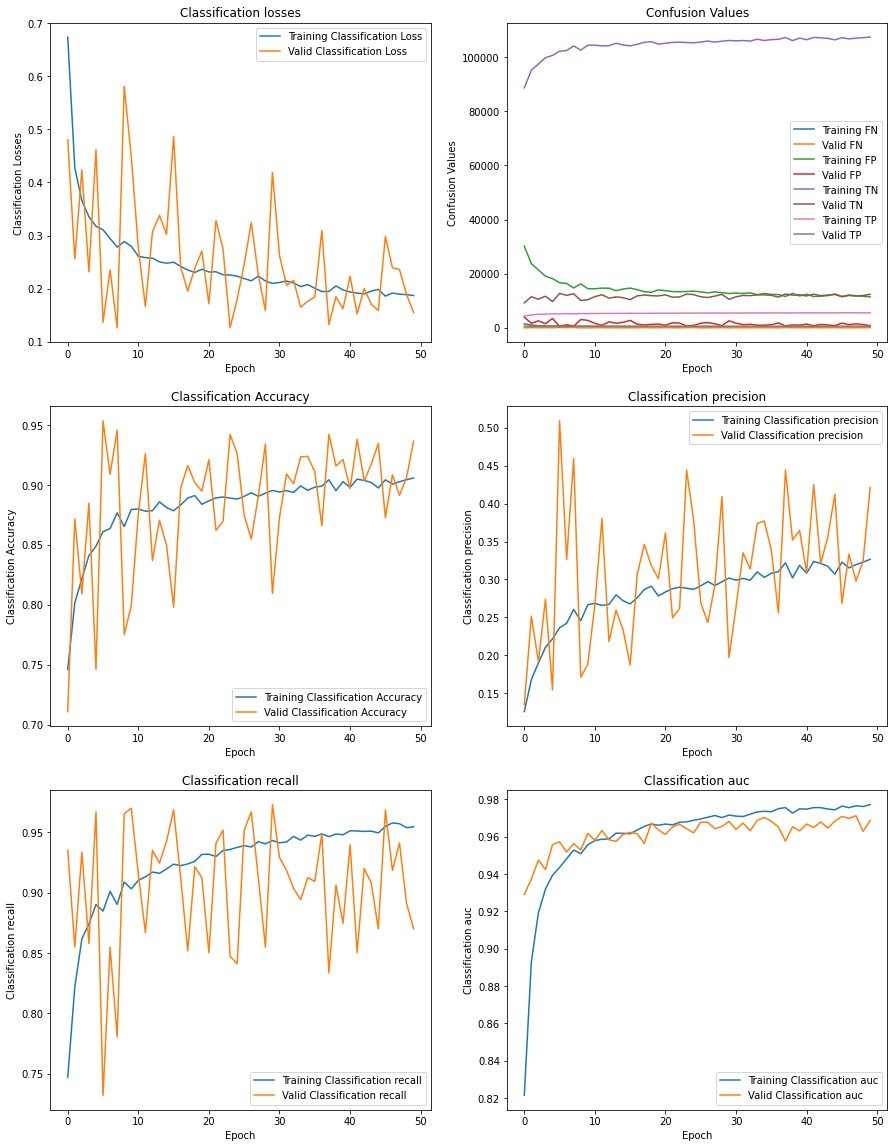

In [ ]:
#training plots
fig = plt.figure(figsize=(15,20))
plt.subplot(3,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Classification losses")
plt.ylabel("Classification Losses")
plt.xlabel("Epoch")
plt.legend(["Training Classification Loss","Valid Classification Loss"])
plt.subplot(3,2,2)
plt.plot(history.history['fn'])
plt.plot(history.history['val_fn'])
plt.plot(history.history['fp'])
plt.plot(history.history['val_fp'])
plt.plot(history.history['tn'])
plt.plot(history.history['val_tn'])
plt.plot(history.history['tp'])
plt.plot(history.history['val_tp'])
plt.title("Confusion Values")
plt.ylabel("Confusion Values")
plt.xlabel("Epoch")
plt.legend(["Training FN","Valid FN","Training FP","Valid FP","Training TN","Valid TN","Training TP","Valid TP"])
plt.subplot(3,2,3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Classification Accuracy")
plt.ylabel("Classification Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Classification Accuracy","Valid Classification Accuracy"])
plt.subplot(3,2,4)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title("Classification precision")
plt.ylabel("Classification precision")
plt.xlabel("Epoch")
plt.legend(["Training Classification precision","Valid Classification precision"])
plt.subplot(3,2,5)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title("Classification recall")
plt.ylabel("Classification recall")
plt.xlabel("Epoch")
plt.legend(["Training Classification recall","Valid Classification recall"])
plt.subplot(3,2,6)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title("Classification auc")
plt.ylabel("Classification auc")
plt.xlabel("Epoch")
plt.legend(["Training Classification auc","Valid Classification auc"])
plt.show()

In [ ]:
Y_test.shape

(15393, 1)

In [ ]:
# predict on test set
y_test_pred = model.predict([off_dataset_test,target_dataset_test])

In [ ]:
y_test_pred.shape

(15393, 1)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

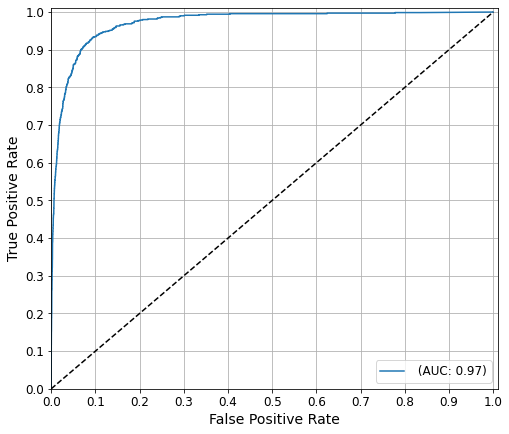

In [ ]:
# Plot of a ROC curve for a specific class
fig, ax = plt.subplots(figsize=(8,7))
ax.plot(fpr[0], tpr[0],label=' (AUC: %0.2f)' % roc_auc[0], alpha=1)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.01])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid()
ax.legend(fontsize=12)
plt.savefig('roc.png', dpi=500, bbox_inches='tight')


In [ ]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(1):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_test_pred[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_test_pred[:, i])

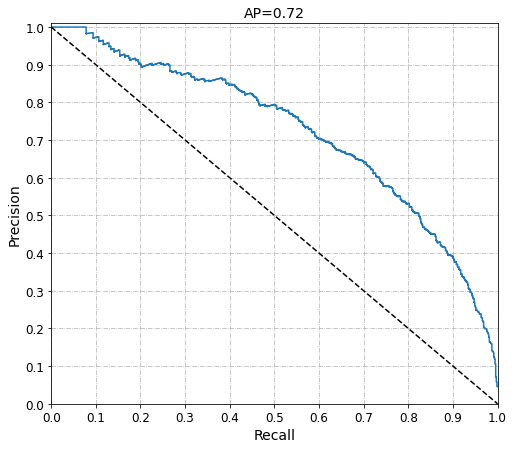

In [ ]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), y_test_pred.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_test_pred, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.00])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title('AP={0:0.2f}'.format(average_precision["micro"]), fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
plt.savefig('aupr.png', dpi=500, bbox_inches='tight')

In [ ]:
#confusion matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

In [ ]:
y_label_pred = np.where(y_test_pred > 0.5, 1, 0)

In [ ]:
y_label_pred,y_label_pred.shape

(array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]), (15393, 1))

In [ ]:
print(metrics.confusion_matrix(Y_test, y_label_pred))

[[13792   898]
 [   82   621]]


In [ ]:
print(metrics.classification_report(Y_test, y_label_pred, digits=3))

              precision    recall  f1-score   support

           0      0.994     0.939     0.966     14690
           1      0.409     0.883     0.559       703

    accuracy                          0.936     15393
   macro avg      0.701     0.911     0.762     15393
weighted avg      0.967     0.936     0.947     15393



In [ ]:
# now testing regression
#########################
#      REGRESSION #######
########################

In [ ]:
freq = output['freq']

In [ ]:
freq,freq.shape

(0         39.0
 1         39.0
 2         38.0
 3         21.0
 4         22.0
           ... 
 153919     0.0
 153920     0.0
 153921     0.0
 153922     0.0
 153923     0.0
 Name: freq, Length: 153924, dtype: float64, (153924,))

In [ ]:
freq = freq.values.reshape(-1,1)
freq

array([[39.],
       [39.],
       [38.],
       ...,
       [ 0.],
       [ 0.],
       [ 0.]])

In [ ]:
#data summary
off_dataset.shape, target_dataset.shape, freq.shape

((153924, 4, 28, 1), (153924, 4, 28, 1), (153924, 1))

In [ ]:
# # data split for 1D- not used, squeeze is used for removing the channel dimension
off_dataset1d = off_dataset.squeeze()
target_dataset1d = target_dataset.squeeze()
off_dataset_train, off_dataset_test, target_dataset_train, target_dataset_test, freq_train, freq_test = train_test_split(off_dataset1d, target_dataset1d,freq, test_size=0.1, random_state=1)

In [ ]:
#now model
try:
  del model, history
except:
  pass

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
#model start
#####################################################

#input_1

input_1 = Input(shape = (4,28))
conv1_1 = Convolution1D(1024, 3, activation = 'relu',padding='same')(input_1)
pool1_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv1_2 = Convolution1D(2048, 3, activation = 'relu',padding='same')(pool1_1)
pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
flat_1 = Flatten()(pool1_2)
 
#input_2

input_2 = Input(shape = (4,28))
conv2_1 = Convolution1D(1024, 3, activation = 'relu',padding='same')(input_2)
pool2_1 = MaxPooling1D(pool_size=2)(conv2_1)
conv2_2 = Convolution1D(2048, 3, activation = 'relu',padding='same')(pool2_1)
pool2_2 = MaxPooling1D(pool_size=2)(conv2_2)
flat_2 = Flatten()(pool2_2)
 
# concatenate
concat   = Concatenate()([flat_1, flat_2])
dense1   = Dense(2048, activation = 'relu')(concat)
#dropout1 = Dropout(0.1)(dense1)
dense2   = Dense(2048, activation = 'relu')(dense1)
dense3   = Dense(1024, activation = 'relu')(dense2)
output   = Dense(1, activation = 'linear')(dense3)
 
# create model with two inputs
model = Model(inputs=[input_1,input_2], outputs=[output])

In [ ]:
#model compile
model.compile(optimizer=keras.optimizers.Adam(lr=0.00001),loss='mse',metrics=['mse'])
#model.compile(optimizer=RMSprop(),loss='mse',metrics=['mse'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.00001, verbose=1)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True, verbose=1)

In [ ]:
history=model.fit([off_dataset_train,target_dataset_train], freq_train, 
                batch_size=32, 
                epochs=100, 
                verbose=1, 
                validation_split=0.1,
                callbacks=[reduce_lr]
                )

Epoch 1/100
3897/3897 [==============================] - 62s 16ms/step - loss: 259.4384 - mse: 259.4384 - val_loss: 523.5470 - val_mse: 523.5470
Epoch 2/100
3897/3897 [==============================] - 62s 16ms/step - loss: 256.2468 - mse: 256.2468 - val_loss: 541.7794 - val_mse: 541.7794
Epoch 3/100
3897/3897 [==============================] - 62s 16ms/step - loss: 251.1961 - mse: 251.1961 - val_loss: 504.9308 - val_mse: 504.9308
Epoch 4/100
3897/3897 [==============================] - 62s 16ms/step - loss: 241.4315 - mse: 241.4315 - val_loss: 525.5750 - val_mse: 525.5750
Epoch 5/100
3896/3897 [============================>.] - ETA: 0s - loss: 241.5815 - mse: 241.5815

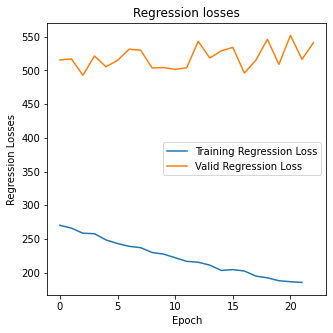

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.title("Regression losses")
plt.ylabel("Regression Losses")
plt.xlabel("Epoch")
plt.legend(["Training Regression Loss","Valid Regression Loss"])
plt.show()

In [ ]:
#model predictions
ypred_train = model.predict([off_dataset_train, target_dataset_train])
ypred_test = model.predict([off_dataset_test, target_dataset_test])

In [ ]:
#freq_train.shape, ypred_train.shape,  freq_test.shape, ypred_test.shape

((138531, 1), (138531, 1), (15393, 1), (15393, 1))

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
print('training_r2', r2_score(freq_train, ypred_train))
print('test_r2', r2_score(freq_test, ypred_test))

training_r2 0.68015315188549
test_r2 0.3161456709307058


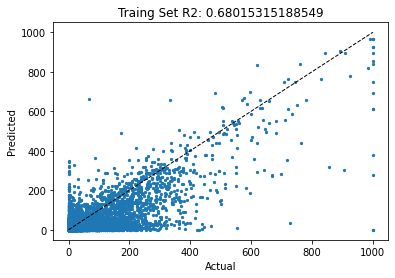

In [ ]:
fig, ax = plt.subplots()
ax.scatter(freq_train, ypred_train,s=5)
ax.plot([freq.min(), freq.max()], [freq.min(), freq.max()], 'k--', lw=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Traing Set R2: ' + str(r2_score(freq_train, ypred_train)),)
plt.show()

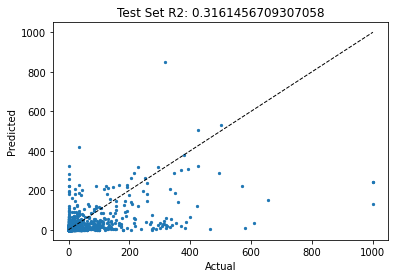

In [ ]:
fig, ax = plt.subplots()
ax.scatter(freq_test, ypred_test,s=5)
ax.plot([freq.min(), freq.max()], [freq.min(), freq.max()], 'k--', lw=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Test Set R2: ' + str(r2_score(freq_test, ypred_test)))
plt.show()

In [19]:
###################
#multitask learning; classification regression from shared layers
###################

In [26]:
#get both types of output
output = pd.read_csv('output2.csv')
y = output['y']
freq = output['freq']

In [27]:
Y = le.fit_transform(y).reshape(-1,1)

In [28]:
Y, Y.shape

(array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]]), (153924, 1))

In [29]:
freq = freq.values.reshape(-1,1)
freq, freq.shape

(array([[39.],
        [39.],
        [38.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]]), (153924, 1))

In [30]:
#data summary
off_dataset.shape, target_dataset.shape, Y.shape, freq.shape

((153924, 4, 28, 1), (153924, 4, 28, 1), (153924, 1), (153924, 1))

In [31]:
#now model
try:
  del model, history
except:
  pass

In [32]:
from keras import backend as K
K.clear_session()

In [33]:
#model
#model start
#####################################################

#input_1

input_1 = Input(shape = (4,28), name='i_1')
conv1_1 = Convolution1D(1024, 3, activation = 'relu',padding='same')(input_1)
pool1_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv1_2 = Convolution1D(1024, 3, activation = 'relu',padding='same')(pool1_1)
pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
flat_1 = Flatten()(pool1_2)
 
#input_2

input_2 = Input(shape = (4,28), name='i_2')
conv2_1 = Convolution1D(1024, 3, activation = 'relu',padding='same')(input_2)
pool2_1 = MaxPooling1D(pool_size=2)(conv2_1)
conv2_2 = Convolution1D(1024, 3, activation = 'relu',padding='same')(pool2_1)
pool2_2 = MaxPooling1D(pool_size=2)(conv2_2)
flat_2 = Flatten()(pool2_2)
 
# concatenate
concat   = Concatenate()([flat_1, flat_2])
dense1   = Dense(2048, activation = 'relu')(concat)
#dropout1 = Dropout(0.1)(dense1)
#dense2   = Dense(1024, activation = 'relu')(dense1)
dense3   = Dense(512, activation = 'relu')(dense1) #goes to regression


#dense4  = Dense(1024, activation = 'relu')(dense1)
dense5  = Dense(1024, activation = 'relu')(dense1) #goes to classification


#regression output
output_1  = Dense(1, activation = 'linear', name='r')(dense3)


#classification output
output_2  = Dense(1, activation = 'sigmoid', name='c')(dense5)
 
# create model with two inputs
model = Model(inputs=[input_1,input_2], outputs=[output_1,output_2])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [34]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i_1 (InputLayer)                (None, 4, 28)        0                                            
__________________________________________________________________________________________________
i_2 (InputLayer)                (None, 4, 28)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4, 1024)      87040       i_1[0][0]                        
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 4, 1024)      87040       i_2[0][0]                        
____________________________________________________________________________________________

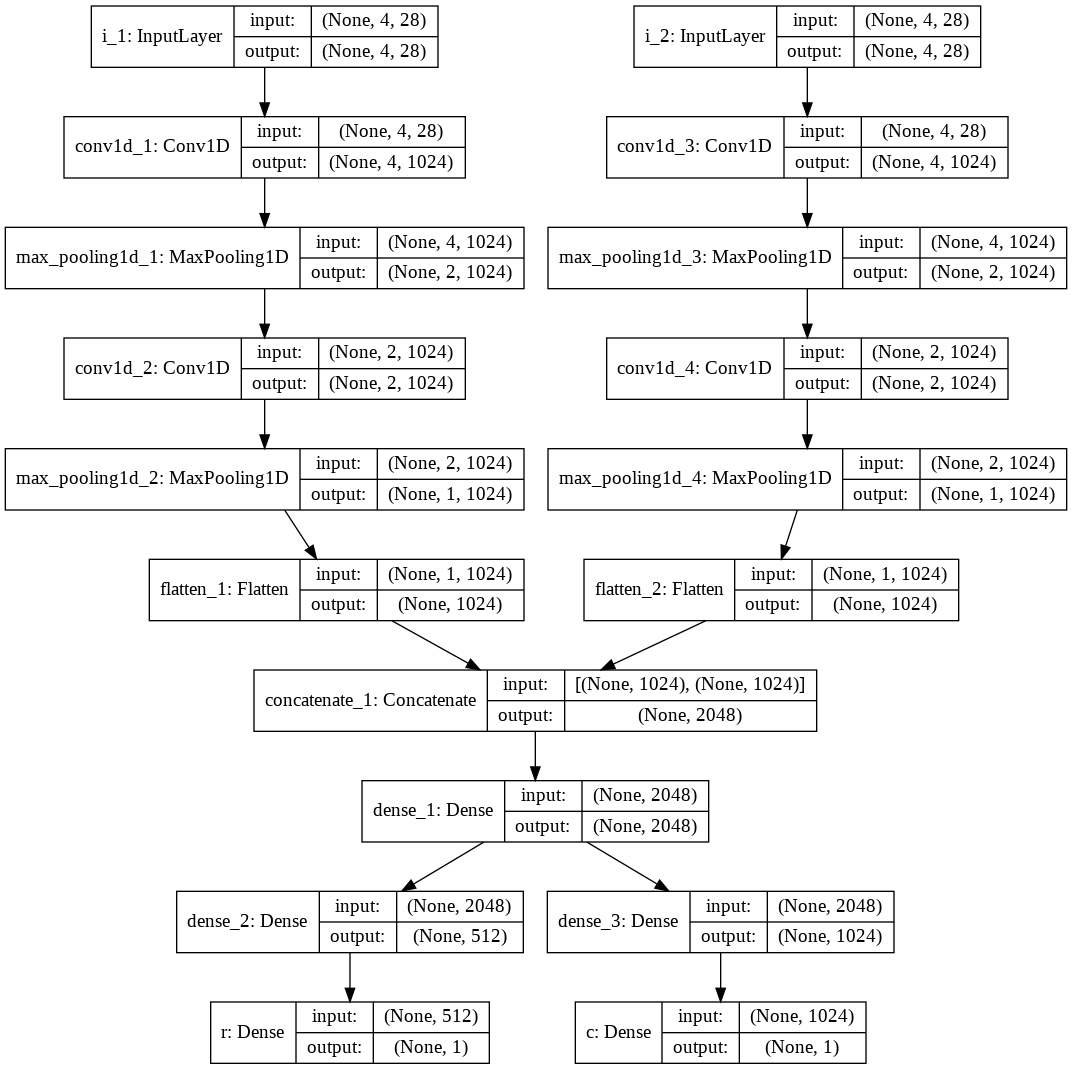

In [35]:
plot_model(model,  to_file='model_multi5_latest.png', show_shapes=True, show_layer_names=True)

In [36]:
#metrics for classification
metrics = [
    #keras.metrics.FalseNegatives(name="fn"),
    #keras.metrics.FalsePositives(name="fp"),
    #keras.metrics.TrueNegatives(name="tn"),
    #keras.metrics.TruePositives(name="tp"),
    #keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc")
]

In [37]:
#model compile is one of the most important step
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss={'r': 'mse','c': 'binary_crossentropy'},
              loss_weights={'r': 0.0001,'c': 1.0},
              metrics={'r':'mse','c':metrics})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
# # data split for 1D- not used, squeeze is used for removing the channel dimension
# use of indexes to refer data later
img_indexes = list(range(0,samples))
off_dataset1d = off_dataset.squeeze()
target_dataset1d = target_dataset.squeeze()
off_dataset_train, off_dataset_test, target_dataset_train, target_dataset_test, Y_train, Y_test, freq_train, freq_test, train_index, test_index = train_test_split(off_dataset1d, target_dataset1d,Y,freq,img_indexes, test_size=0.1, random_state=1)

In [39]:
#train summary
off_dataset_train.shape,target_dataset_train.shape,freq_train.shape,Y_train.shape

((138531, 4, 28), (138531, 4, 28), (138531, 1), (138531, 1))

In [40]:
#test summary
off_dataset_test.shape, target_dataset_test.shape, freq_test.shape,Y_test.shape

((15393, 4, 28), (15393, 4, 28), (15393, 1), (15393, 1))

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30,restore_best_weights=True, verbose=1)

In [42]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.00000001, verbose=1)

In [100]:
# history=model.fit({'i_1': off_dataset_train,'i_2' : target_dataset_train},
#                   {'r':freq_train,'c': Y_train}, 
#                 batch_size=16, epochs=50,
#                 validation_split=0.1)
#                 #validation_data=({'i_1':off_dataset_test,'i_2':target_dataset_test},{'r': freq_test,'c': Y_test}),
#                 #verbose=1)

In [43]:
try:
  history=model.fit([off_dataset_train,target_dataset_train],[freq_train,Y_train], 
                  batch_size=16, epochs=30, 
                  #validation_data=([off_dataset_test,target_dataset_test],[freq_test,Y_test]),
                  #class_weight={0: 0.525, 1: 10.704},
                  validation_split=0.1,
                  class_weight={'c': {0: 0.525, 1: 10.704}},
                  callbacks=[reduce_lr],verbose=1)
except KeyboardInterrupt:
  model.save('model_multi5_latest.hdf5')
  print('Model saved to drive')


Train on 124677 samples, validate on 13854 samples
Epoch 1/40
124677/124677 [==============================] - 265s 2ms/step - loss: 0.8729 - r_loss: 823.0729 - c_loss: 0.7910 - r_mse: 819.8355 - c_precision: 0.1436 - c_recall: 0.7690 - c_auc: 0.8388 - val_loss: 0.3974 - val_r_loss: 706.6628 - val_c_loss: 0.3267 - val_r_mse: 706.7580 - val_c_precision: 0.2338 - val_c_recall: 0.8729 - val_c_auc: 0.9359
Epoch 2/40
124677/124677 [==============================] - 255s 2ms/step - loss: 0.4468 - r_loss: 771.0359 - c_loss: 0.3697 - r_mse: 771.1037 - c_precision: 0.2038 - c_recall: 0.8361 - c_auc: 0.9173 - val_loss: 0.4375 - val_r_loss: 678.6123 - val_c_loss: 0.3695 - val_r_mse: 678.7076 - val_c_precision: 0.3959 - val_c_recall: 0.7216 - val_c_auc: 0.9416
Epoch 3/40
124677/124677 [==============================] - 255s 2ms/step - loss: 0.4058 - r_loss: 754.7759 - c_loss: 0.3303 - r_mse: 754.8414 - c_precision: 0.2224 - c_recall: 0.8685 - c_auc: 0.9338 - val_loss: 0.3725 - val_r_loss: 680.192

In [44]:
model.save('model_multi5_latest.hdf5')

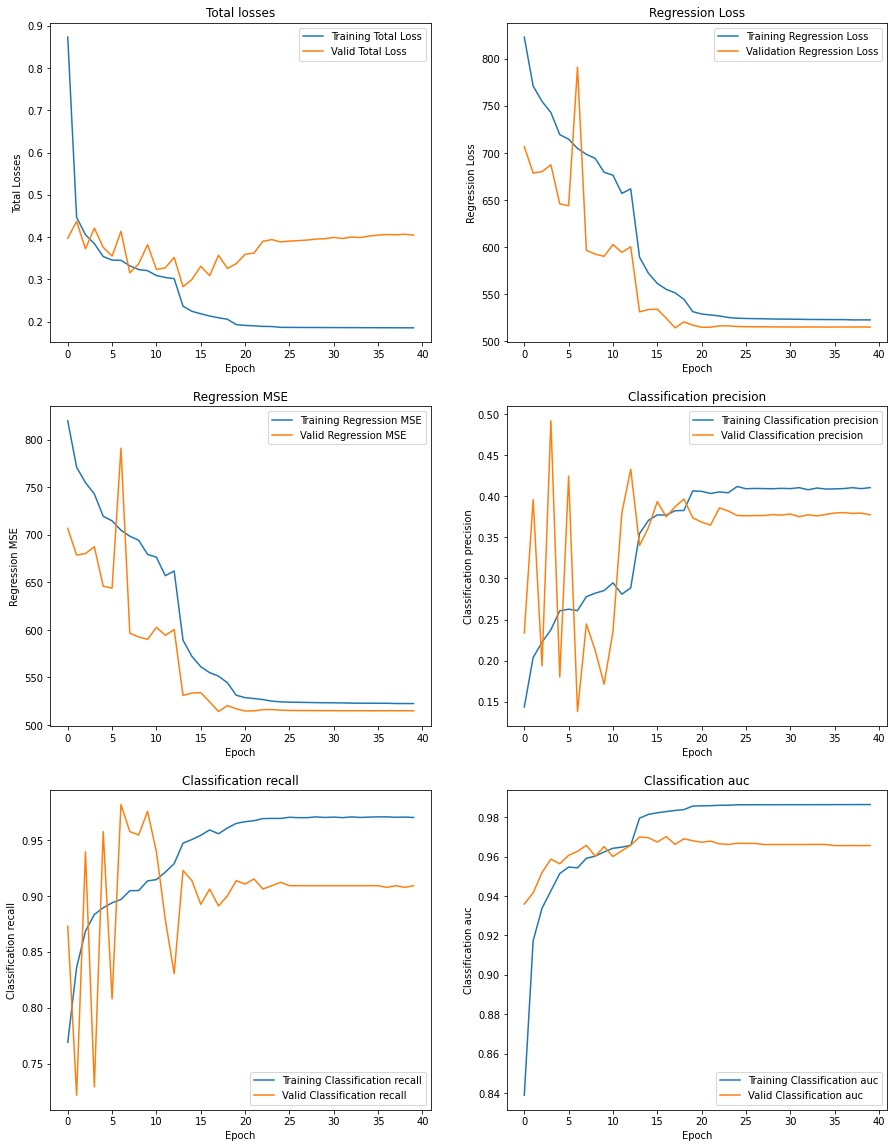

In [45]:
#training plots
fig = plt.figure(figsize=(15,20))
plt.subplot(3,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Total losses")
plt.ylabel("Total Losses")
plt.xlabel("Epoch")
plt.legend(["Training Total Loss","Valid Total Loss"])
plt.subplot(3,2,2)
plt.plot(history.history['r_loss'])
plt.plot(history.history['val_r_loss'])
plt.title("Regression Loss")
plt.ylabel("Regression Loss")
plt.xlabel("Epoch")
plt.legend(["Training Regression Loss","Validation Regression Loss"])
plt.subplot(3,2,3)
plt.plot(history.history['r_mse'])
plt.plot(history.history['val_r_mse'])
plt.title("Regression MSE")
plt.ylabel("Regression MSE")
plt.xlabel("Epoch")
plt.legend(["Training Regression MSE","Valid Regression MSE"])
plt.subplot(3,2,4)
plt.plot(history.history['c_precision'])
plt.plot(history.history['val_c_precision'])
plt.title("Classification precision")
plt.ylabel("Classification precision")
plt.xlabel("Epoch")
plt.legend(["Training Classification precision","Valid Classification precision"])
plt.subplot(3,2,5)
plt.plot(history.history['c_recall'])
plt.plot(history.history['val_c_recall'])
plt.title("Classification recall")
plt.ylabel("Classification recall")
plt.xlabel("Epoch")
plt.legend(["Training Classification recall","Valid Classification recall"])
plt.subplot(3,2,6)
plt.plot(history.history['c_auc'])
plt.plot(history.history['val_c_auc'])
plt.title("Classification auc")
plt.ylabel("Classification auc")
plt.xlabel("Epoch")
plt.legend(["Training Classification auc","Valid Classification auc"])
plt.show()

In [46]:
# predict on test set
yreg_pred, ycls_pred = model.predict([off_dataset_test,target_dataset_test])

In [47]:
# predict on training set for regression comparison of r2
yreg_pred_train, _ = model.predict([off_dataset_train,target_dataset_train])

In [48]:
yreg_pred.shape, ycls_pred.shape

((15393, 1), (15393, 1))

In [49]:
#plots
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], ycls_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

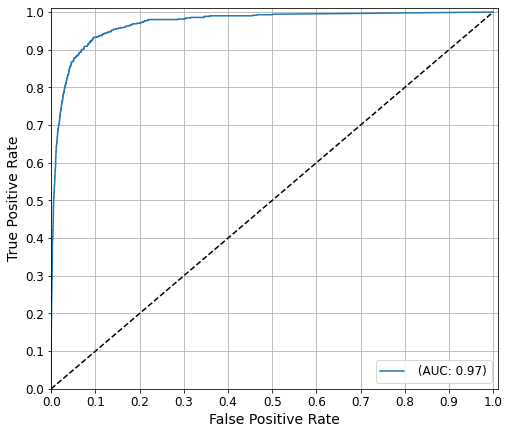

In [50]:
# Plot of a ROC curve for a specific class
fig, ax = plt.subplots(figsize=(8,7))
ax.plot(fpr[0], tpr[0],label=' (AUC: %0.2f)' % roc_auc[0], alpha=1)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.01])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid()
ax.legend(fontsize=12)
plt.savefig('roc.png', dpi=500, bbox_inches='tight')

In [51]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(1):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], ycls_pred[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], ycls_pred[:, i])

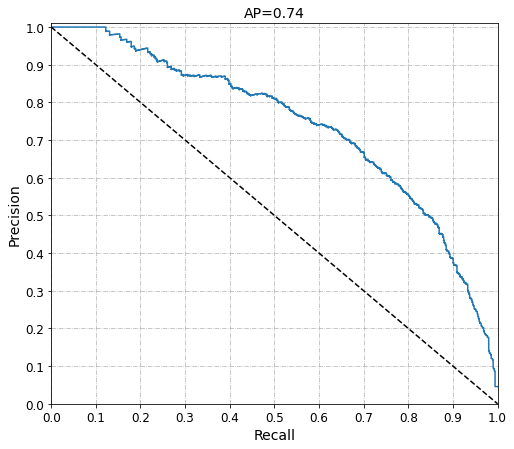

In [52]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), ycls_pred.ravel())
average_precision["micro"] = average_precision_score(Y_test, ycls_pred, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.00])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title('AP={0:0.2f}'.format(average_precision["micro"]), fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
plt.savefig('aupr.png', dpi=500, bbox_inches='tight')

In [53]:
#confusion matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics as sklearn_metrics

In [54]:
y_label_pred = np.where(ycls_pred > 0.5, 1, 0)

In [55]:
y_label_pred,y_label_pred.shape

(array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]), (15393, 1))

In [56]:
print(sklearn_metrics.confusion_matrix(Y_test, y_label_pred))

[[13610  1080]
 [   69   634]]


In [57]:
print(sklearn_metrics.classification_report(Y_test, y_label_pred, digits=3))

              precision    recall  f1-score   support

           0      0.995     0.926     0.959     14690
           1      0.370     0.902     0.525       703

    accuracy                          0.925     15393
   macro avg      0.682     0.914     0.742     15393
weighted avg      0.966     0.925     0.940     15393



In [58]:
#now regression
freq_train.shape, yreg_pred_train.shape

((138531, 1), (138531, 1))

In [133]:
freq_test.shape, yreg_pred.shape

((15393, 1), (15393, 1))

In [134]:
from sklearn.metrics import r2_score

In [135]:
print('training_r2', r2_score(freq_train, yreg_pred_train))
print('test_r2', r2_score(freq_test, yreg_pred))

training_r2 0.5451901253425476
test_r2 0.3179886297312058


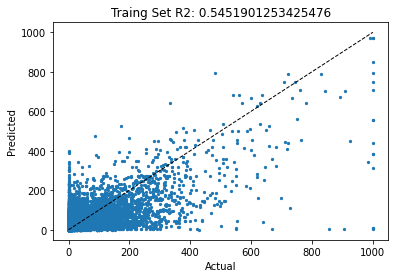

In [136]:
fig, ax = plt.subplots()
ax.scatter(freq_train, yreg_pred_train,s=5)
ax.plot([freq.min(), freq.max()], [freq.min(), freq.max()], 'k--', lw=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Traing Set R2: ' + str(r2_score(freq_train, yreg_pred_train)),)
plt.show()

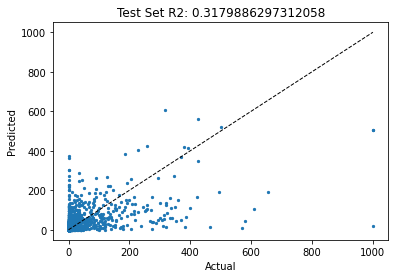

In [137]:
fig, ax = plt.subplots()
ax.scatter(freq_test, yreg_pred,s=5)
ax.plot([freq.min(), freq.max()], [freq.min(), freq.max()], 'k--', lw=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Test Set R2: ' + str(r2_score(freq_test, yreg_pred)))
plt.show()

In [ ]:
# # weighted binary crossentropy
# def get_weighted_loss(weights):
#     def weighted_loss(y_true, y_pred):
#         return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
#     return weighted_loss

# model.compile(optimizer=Adam(), loss=get_weighted_loss(class_weights))

In [1]:
#lost?